<a href="https://colab.research.google.com/github/argareeva/DataAnalyticsProject/blob/main/%D0%A4%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D1%81%D0%BE%D1%81%D1%82%D0%B0%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
!pip install shap

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Прекурсор       10 non-null     int64  
 1   Растворитель    10 non-null     int64  
 2   t, C            10 non-null     int64  
 3   t, ч            10 non-null     int64  
 4   pH              10 non-null     float64
 5   HNO3            10 non-null     int64  
 6   CH3COOH         10 non-null     int64  
 7   HCl             10 non-null     int64  
 8   H2SO4           10 non-null     int64  
 9   Фазовый состав  10 non-null     int64  
dtypes: float64(1), int64(9)
memory usage: 928.0 bytes
None
       Прекурсор  Растворитель        t, C       t, ч         pH       HNO3  \
count  10.000000     10.000000   10.000000  10.000000  10.000000  10.000000   
mean   12.300000     21.900000   46.200000  22.400000   5.160000   3.100000   
std     0.674949      0.316228   47.332864   5.059644   2.106

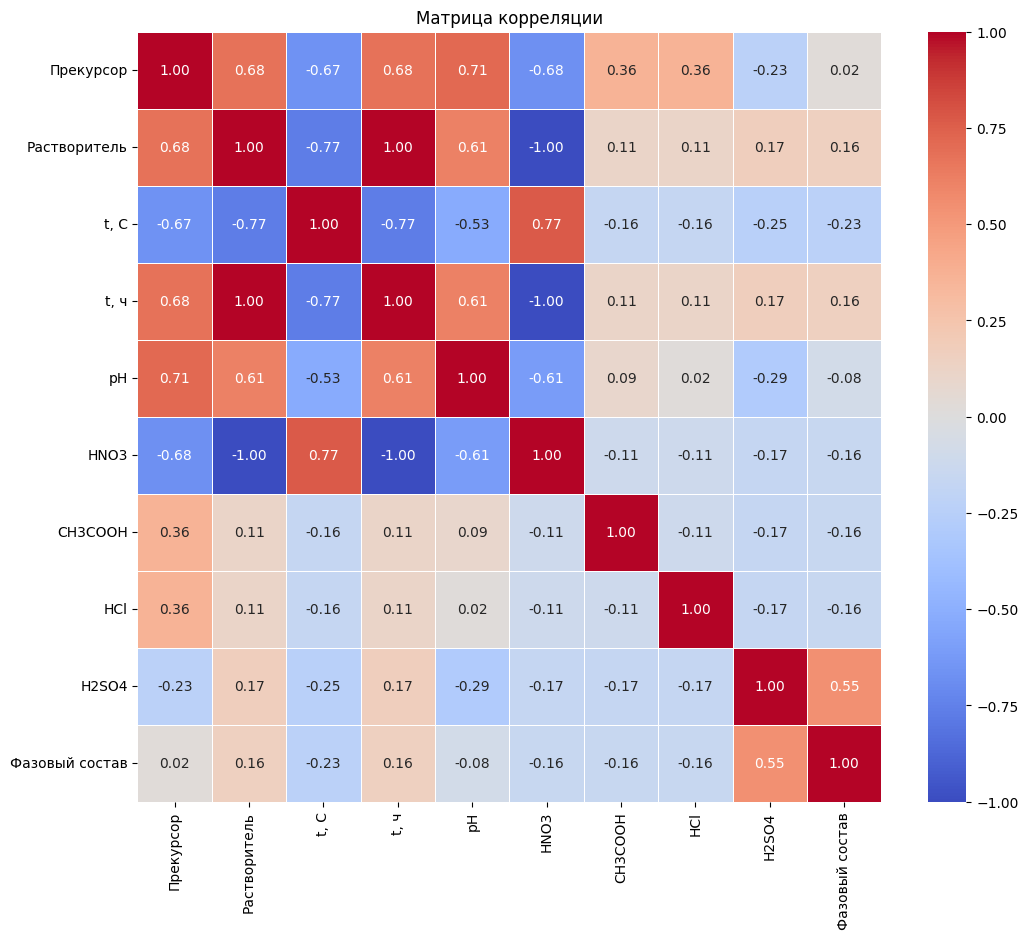

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('Book3.csv', delimiter=';')
data_numeric = data.drop(columns=['#', 't1, C', 'H1, Дж/г', 't2, C', 'H2, Дж/г', 'A1(C)', 'A2(C)', 'A1(O)', 'A2(O)', 'A1(Fe)', 'A2(Fe)'])

print(data_numeric.info())
print(data_numeric.describe())

correlation_matrix = data_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

In [53]:
data_numeric.head()

,Прекурсор,Растворитель,"t, C","t, ч",pH,HNO3,CH3COOH,HCl,H2SO4,Фазовый состав
0,11,21,150,8,1.5,31,0,0,0,41
1,12,22,24,24,6.0,0,0,0,0,41
2,12,22,24,24,5.0,0,0,0,0,41
3,13,22,24,24,5.7,0,31,0,0,41
4,13,22,24,24,9.4,0,0,0,0,42


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X = data_numeric.drop(columns=['Фазовый состав'])
y = data_numeric['Фазовый состав']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'MAE (Linear Regression): {mae:.4}')
print(f'MSE (Linear Regression): {mse:.4}')

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': lr_model.coef_})
print(feature_weights)

MAE (Linear Regression): 1.541
MSE (Linear Regression): 3.987
        Feature        Weight
0     Прекурсор -1.891892e-01
1  Растворитель -6.213110e-04
2          t, C -5.551115e-17
3          t, ч -9.940975e-03
4            pH  2.702703e-01
5          HNO3  1.926064e-02
6       CH3COOH  2.775558e-17
7           HCl  3.487358e-03
8         H2SO4  8.631212e-02


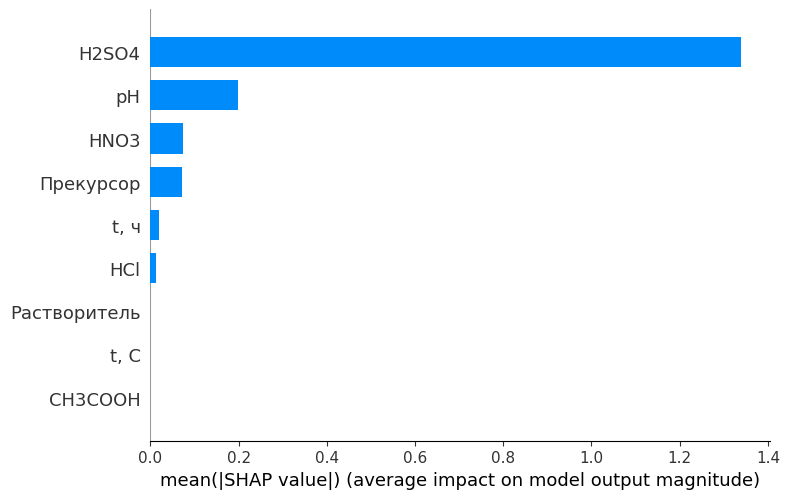

In [55]:
import shap

explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_test)
shap.summary_plot(explainer_lr.shap_values(X_test), X_test, plot_type="bar", feature_names=X_test.columns)

In [56]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=1)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt_model, param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search_dt.fit(X_train, y_train)

print("Оптимальные параметры:", grid_search_dt.best_params_)

cv_scores = cross_val_score(grid_search_dt.best_estimator_, X_train, y_train, cv=4, scoring='neg_mean_squared_error')
print("Среднее значение MSE на кросс-валидации:", -cv_scores.mean())

y_pred_dt = grid_search_dt.best_estimator_.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)

print(f'MAE (Tuned Decision Tree): {mae_dt:.4}')
print(f'MSE (Tuned Decision Tree): {mse_dt:.4}')

Оптимальные параметры: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Среднее значение MSE на кросс-валидации: 0.6180555555555562
MAE (Tuned Decision Tree): 0.375
MSE (Tuned Decision Tree): 0.1406


In [58]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [3, 5, 10],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(rf_model, param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

print("Оптимальные параметры:", grid_search_rf.best_params_)

y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f'MAE (Tuned Random Forest): {mae_rf:.4}')
print(f'MSE (Tuned Random Forest): {mse_rf:.4f}')

Оптимальные параметры: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 10}
MAE (Tuned Random Forest): 0.1625
MSE (Tuned Random Forest): 0.0264


In [59]:
rf_model_tuned = RandomForestRegressor(n_estimators=5, max_depth=5, min_samples_leaf=2, min_samples_split=10, random_state=42)
rf_model_tuned.fit(X_train, y_train)

y_pred_rf_tuned = rf_model_tuned.predict(X_test)

mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)

print(f'MAE (Random Forest): {mae_rf_tuned:.4}')
print(f'MSE (Random Forest): {mse_rf_tuned:.4}')

MAE (Random Forest): 0.325
MSE (Random Forest): 0.1056


In [60]:
from sklearn.model_selection import LeaveOneOut

cv_scores = cross_val_score(grid_search_dt.best_estimator_, X, y, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
print("Среднее значение MSE на LOOCV:", -cv_scores.mean())

Среднее значение MSE на LOOCV: 0.506172839506173


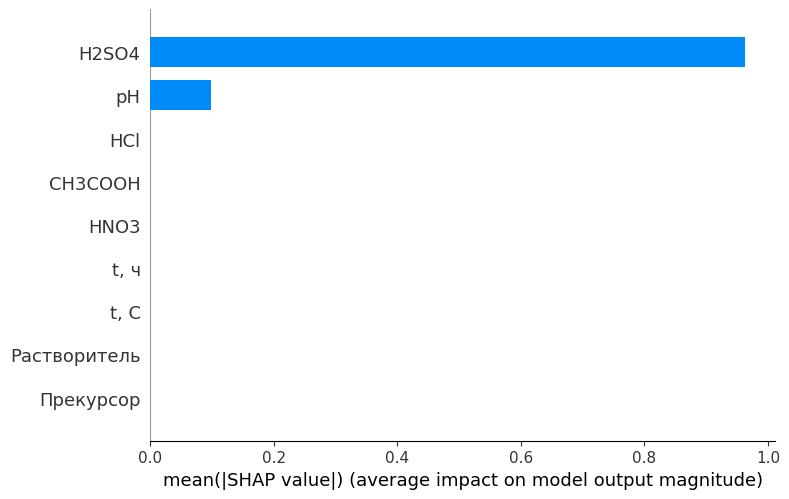

In [61]:
import shap

explainer = shap.Explainer(rf_model_tuned, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(explainer_xgboost.shap_values(X_test), X_test, plot_type="bar", feature_names=X_test.columns)